In [1]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import sys
sys.path.insert(1, '../../SyMBac/')


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from microfilm.colorify import cmaps_def
import scipy
from statannotations.Annotator import Annotator
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')
from numba import njit
matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True

resize_amount = 1
pix_mic_conv = 0.065 / 17


all_data = pd.read_pickle("../../single_cell_projection_diffraction/all_data.pickle")

wavelength_colours = ["k", "b", "g", "orange", "r"] 

standard_cell = all_data.query("`True Width` == 1.04")
max_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].max()
min_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].min()
mid_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].unique()[1]

correction_cell = standard_cell.query("`Imaging Modality` == 'membrane' & `Wavelength` == 0 & `Depth of Focus` == @max_dof_membrane").iloc[0]

max_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].max()
min_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].min()
mid_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].unique()[1]
high_dof_wavelength_FL = standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @max_dof_FL").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
low_dof_wavelength_FL = standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @min_dof_FL").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
mid_dof_wavelength_FL= standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @mid_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()

high_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
low_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @min_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
mid_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @mid_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()


high_low_dof = pd.concat([high_dof_wavelength_FL, low_dof_wavelength_FL, high_dof_wavelength_membrane, low_dof_wavelength_membrane, mid_dof_wavelength_membrane, mid_dof_wavelength_FL])
imshow_data = all_data.loc[high_low_dof.index]

profiles = []
for index, row in imshow_data.iterrows():
    profiles.append(row["profile"])

max_int = np.max(profiles)
#profiles[0] = profiles[0]/profiles[0].max() * max_int

profiles = [x/x.max() * max_int for x in profiles]

x_axes = []
for plot_profile in profiles:
    x_axis = np.arange(0,len(plot_profile),1).astype(float)
    x_axis -= x_axis.max()/2
    x_axis *= pix_mic_conv
    x_axes.append(x_axis)

imshow_data["profile"] = profiles
imshow_data["x axis"] = x_axes
imshow_data = imshow_data.explode(["profile", "x axis"])

def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
            
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    if additional_width<=1:
        new_cell[np.where(new_cell)] += int(abs(additional_width))
    
    return new_cell

@njit
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness) + centreline - int(np.ceil(thickness ))

@njit
def gen_3D_coords_from_2D(test_cells, centreline, thickness):
    return np.where(test_cells == thickness) + (generate_deviation_from_CL(centreline, thickness),)

@njit
def convert_to_3D_numba(cell):
    expanded_scene = cell
    volume_shape = expanded_scene.shape[0:] + (int(expanded_scene.max()*2),)
    test_cells = rounder(expanded_scene)
    centreline = int(expanded_scene.max() )
    cells_3D = np.zeros(volume_shape,dtype = np.ubyte)
    for t in range(int(expanded_scene.max() *2 )):
        test_coords = gen_3D_coords_from_2D(test_cells, centreline, t)
        for x, y in zip(test_coords[0], (test_coords[1])):
            for z in test_coords[2]:
                cells_3D[x, y, z] = 1
    return cells_3D

def convert_to_3D(cell):
    cells_3D = convert_to_3D_numba(cell)
    cells_3D = np.moveaxis(cells_3D, -1, 0)
    cells_3D[cells_3D.shape[0]//2:,:, :] = cells_3D[:cells_3D.shape[0]//2,:, :][::-1]
    return cells_3D
    #cells_3D = np.pad(cells_3D, ((100,100), (50,50), (50,50)))
#cells_3D.shape

@njit
def rounder(x):
    out = np.empty_like(x)
    np.round(x, 0, out)
    return out

def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):


    membrane_thickness = 0.05 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

def raster_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):

    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    
    cell_3d = cell_1_3d 
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

additional_width = 0
raster_additional_width = 0

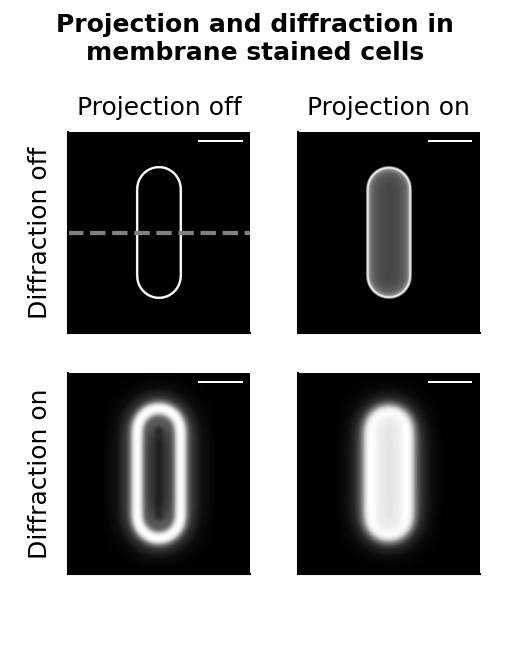

In [2]:
fig, ((mem_00, mem_10),(mem_01, mem_11)) = plt.subplots(2, 2, figsize = (1.7,2.2), dpi = 300)
mem_00.imshow( np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )
mem_00.plot([mem_00.get_xlim()[0], mem_00.get_xlim()[1]],  [mem_00.get_ylim()[0]/2, mem_00.get_ylim()[0]/2], linestyle="--", c = "grey")
mem_10.imshow( np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )
mem_01.imshow( np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0.7 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )
mem_11.imshow( np.load('../../single_cell_projection_diffraction/'+imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0.7 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )


for ax in [mem_00, mem_10, mem_01, mem_11]:
    ax.set_xticks([])
    ax.set_yticks([])

mem_00.set_xlabel('Projection off')    
mem_00.xaxis.set_label_position('top') 
mem_00.set_ylabel("Diffraction off")

mem_10.set_xlabel("Projection on")
mem_10.xaxis.set_label_position('top') 

mem_01.set_ylabel("Diffraction on")


for ax in [mem_00, mem_10, mem_01, mem_11]:
    ax.set_xticks([])
    ax.set_yticks([])
    scalebar = ScaleBar(pix_mic_conv, "um", length_fraction=0.25, scale_loc="none",box_alpha=0, color="white", box_color="k") # 1 micon
    ax.add_artist(scalebar)
plt.suptitle("Projection and diffraction in\nmembrane stained cells", fontsize=6, weight = "bold")
plt.subplots_adjust(bottom=0.13, top = 0.8, right =  0.95)
plt.savefig("a.svg")

In [3]:
melted_data = pd.read_pickle("../../single_cell_projection_diffraction/membrane_targeted_simulation_data.pickle")

In [4]:
pix_mic_conv = 0.065 / 15
resize_amount = 1
sim_width = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.7 & `PSF Type` == 'ePSF'")["True Width"].iloc[0]

In [5]:
a_cell = np.pad(raster_membrane_cell_3d(3/pix_mic_conv, sim_width/pix_mic_conv, 0), ((0,0), (50, 50), (50,50)))
unconv_profile = a_cell.sum(axis=0)[a_cell.shape[1]//2]
unconv_profile = unconv_profile/unconv_profile.max()

In [6]:
plot_profile_red = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.7 & `PSF Type` == 'ePSF'")["Profile"].iloc[0]
plot_profile_red = plot_profile_red/plot_profile_red.max()

plot_profile_green = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.5 & `PSF Type` == 'ePSF'")["Profile"].iloc[0]
plot_profile_green = plot_profile_green/plot_profile_green.max()

plot_profile_green_tPSF = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.5 & `PSF Type` == 'tPSF'")["Profile"].iloc[0]
plot_profile_green_tPSF = plot_profile_green_tPSF/plot_profile_green_tPSF.max()

plot_profile_red_tPSF = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.7 & `PSF Type` == 'tPSF'")["Profile"].iloc[0]
plot_profile_red_tPSF = plot_profile_red_tPSF/plot_profile_red_tPSF.max()

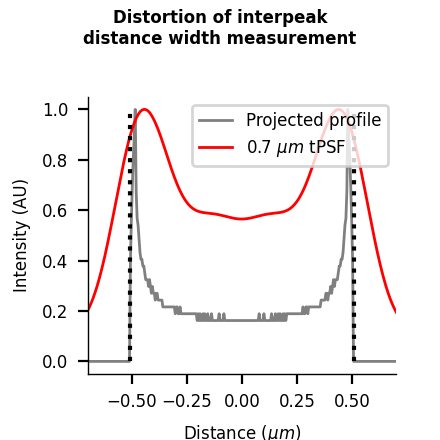

In [95]:
fig, ax = plt.subplots(1,1, figsize=(2.2,2.2), dpi = 200)
plt.xlabel("Distance ($\mu m$)")
plt.ylabel("Intensity (AU)")
plt.subplots_adjust(left=0.2, top = 0.78, bottom=0.15, right = 0.9)

x_axis = np.arange(-len(unconv_profile)/2,len(unconv_profile)/2) * pix_mic_conv
x_axis_tPSF = np.arange(-len(plot_profile_red_tPSF)/2,len(plot_profile_red_tPSF)/2) * pix_mic_conv
plt.plot(x_axis,unconv_profile, c = "grey", label = "Projected profile")
plt.plot(x_axis_tPSF,plot_profile_red_tPSF, c = "red", label = "0.7 $\mu m$ tPSF")
left_border = np.nonzero(unconv_profile)[0][0]
right_border = np.nonzero(unconv_profile)[0][-1]
plt.plot([-sim_width/2, -sim_width/2],[0,1], c = "k", linestyle = ":", linewidth=1.5)
plt.plot([sim_width/2, sim_width/2],[0,1], c = "k", linestyle = ":", linewidth=1.5)
plt.xlim(-0.7,0.7)
plt.legend()
plt.suptitle("Distortion of interpeak\ndistance width measurement", fontsize=6, weight = "bold")
plt.savefig("b.svg")

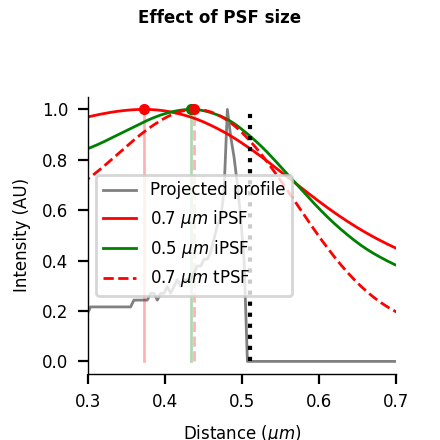

In [97]:
fig, ax = plt.subplots(1,1, figsize=(2.2,2.2), dpi = 200)
plt.xlabel("Distance ($\mu m$)")
plt.ylabel("Intensity (AU)")
plt.subplots_adjust(left=0.2, top = 0.78, bottom=0.15, right = 0.9)
x_axis = np.arange(-len(unconv_profile)/2,len(unconv_profile)/2) * pix_mic_conv
tPSF_x_axis = np.arange(-len(plot_profile_green_tPSF)/2,len(plot_profile_green_tPSF)/2) * pix_mic_conv
plt.plot(x_axis,unconv_profile, c = "grey", label = "Projected profile")

plt.plot(x_axis,plot_profile_red, c = "red", label = "0.7 $\mu m$ iPSF")
_peak = find_peaks(plot_profile_red, height = 0.98)[0]
plt.scatter(x_axis[_peak],plot_profile_red[_peak], c = "red")
plt.plot([x_axis[_peak], x_axis[_peak]],[0, plot_profile_red[_peak]], c = "red", alpha = 0.3)


plt.plot(x_axis,plot_profile_green, c = "green", label = "0.5 $\mu m$ iPSF")
_peak = find_peaks(plot_profile_green, height = 0.98)[0][-1]
plt.scatter(x_axis[_peak],plot_profile_green[_peak], c = "green")
plt.plot([x_axis[_peak], x_axis[_peak]],[0, plot_profile_green[_peak]], c = "green", alpha = 0.3)

plt.plot(tPSF_x_axis,plot_profile_red_tPSF, c = "red", linestyle = "--", label = "0.7 $\mu m$ tPSF")
_peak = find_peaks(plot_profile_red_tPSF, height = 0.98)[0][-1]
plt.scatter(tPSF_x_axis[_peak],plot_profile_red_tPSF[_peak], c = "red")
plt.plot([tPSF_x_axis[_peak], tPSF_x_axis[_peak]],[0, plot_profile_red_tPSF[_peak]], c = "red", alpha = 0.3, linestyle = "--")

left_border = np.nonzero(unconv_profile)[0][0]
right_border = np.nonzero(unconv_profile)[0][-1]
plt.plot([-sim_width/2, -sim_width/2],[0,1], c = "k", linestyle = ":", linewidth=1.5)
plt.plot([sim_width/2, sim_width/2],[0,1], c = "k", linestyle = ":", linewidth=1.5)
plt.xlim(0.3,0.7)
plt.suptitle("Effect of PSF size", fontsize=6, weight = "bold")
plt.legend()
plt.savefig("c.svg")

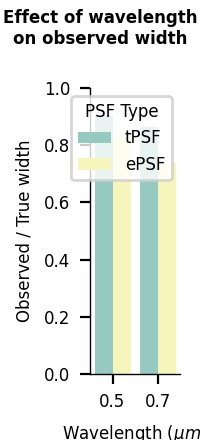

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(1, 2.2), dpi=200)

sns.barplot(data=melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & (`Wavelength` == 0.5 or `Wavelength` == 0.7)"),
            x="Wavelength",
            y="Observed Width / True Width",
            hue="PSF Type",
            palette="Set3",
            hue_order=["tPSF", "ePSF"])  # Flipping the order of the PSF Type categories

plt.subplots_adjust(top=0.8, left=0.45, bottom=0.15, right=0.9)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Observed / True width")
plt.ylim(0, 1)
plt.suptitle("Effect of wavelength\non observed width", fontsize=6, weight = "bold")
plt.savefig("d.svg")


In [72]:
barplot_data = pd.read_pickle("../../FDAA_width_analysis/barplot_data.pickle")
width_data = pd.read_pickle("../../FDAA_width_analysis/plotting_data.pickle")

/tmp/ipykernel_1507417/3462109202.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=barplot_data, y = "value", x = "variable",  ax=WIDTH_BARPLOT, palette=["blue", "red"], order = ["HADA", "RADA"])


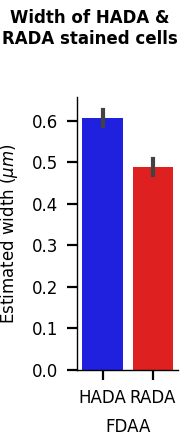

In [46]:


fig, WIDTH_BARPLOT = plt.subplots(1, 1, figsize = (0.9,2.2), dpi = 200)

stat, pvalue = scipy.stats.ttest_ind(width_data["RADA"], width_data["HADA"])

sns.barplot(data=barplot_data, y = "value", x = "variable",  ax=WIDTH_BARPLOT, palette=["blue", "red"], order = ["HADA", "RADA"])
#pairs = [("HADA", "RADA")]
#annotator = Annotator(WIDTH_BARPLOT, pairs, data=barplot_data, x="variable", y="value", order=["HADA", "RADA"])
#annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
#annotator.apply_and_annotate()
plt.ylabel("Width ($\mu$m)")
plt.xlabel("FDAA")
plt.suptitle("Width of HADA &\nRADA stained cells", fontsize=6, weight = "bold")
fig.subplots_adjust(left=0.43, bottom=0.16, right=0.99, top=0.78)
plt.ylabel("Estimated width ($\mu m$)")
plt.savefig("e1.svg")

/tmp/ipykernel_1507417/2090726941.py:30: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(HADA_RADA_PROFILE,[0.9, 0.5, 0.9, 0.5])


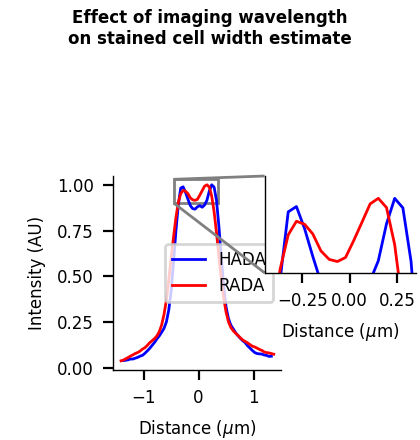

In [55]:
HADA_line = np.load("../../FDAA_width_analysis/HADA_line.npy")
RADA_line = np.load("../../FDAA_width_analysis/RADA_line.npy")

fig, HADA_RADA_PROFILE = plt.subplots(1, 1, figsize = (2.1,2.2), dpi = 200)

HADA_profile = HADA_line[10:-5]/HADA_line.max()
RADA_profile = RADA_line[10:-5]/RADA_line.max()
HADA_x_axis = np.arange(-len(HADA_profile)/2, +len(HADA_profile)/2)*0.065/1.5
RADA_x_axis = np.arange(-len(RADA_profile)/2, +len(RADA_profile)/2)*0.065/1.5


HADA_RADA_PROFILE.plot(HADA_x_axis, HADA_profile, c="b", label="HADA")
HADA_RADA_PROFILE.plot(RADA_x_axis, RADA_profile, c = "r", label = "RADA")
plt.legend()
plt.xlabel("Distance ($\mu$m)")
plt.ylabel("Intensity (AU)")
axins1 = inset_axes(HADA_RADA_PROFILE, 0.275 , 0.75, "upper center",) 

mark_inset(HADA_RADA_PROFILE, axins1, loc1=2, loc2=3, fc="none", ec="0.5")

axins1.set_yticks([])
#axins1.set_xticklabels([])

axins1.plot(HADA_x_axis, HADA_profile, c="b", label="HADA")
axins1.plot(RADA_x_axis, RADA_profile, c = "r", label = "RADA")
axins1.set_xlim(-0.45,0.35)
axins1.set_ylim(0.9,1.03)
axins1.set_xlabel("Distance ($\mu$m)")
axins1.set_ylabel(None)
ip = InsetPosition(HADA_RADA_PROFILE,[0.9, 0.5, 0.9, 0.5])
axins1.set_axes_locator(ip)

plt.suptitle("Effect of imaging wavelength\non stained cell width estimate", fontsize=6,weight = "bold")
fig.subplots_adjust(left=0.27, bottom=0.16, right=0.67, top=0.6)
plt.savefig("e2.svg")

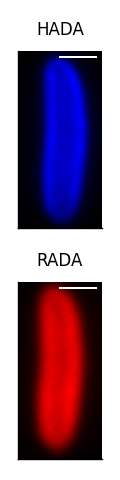

In [13]:
fig, (HADA_IMSHOW, RADA_IMSHOW) = plt.subplots(2,1, figsize = (0.6,2.4), dpi = 200)

for ax in [HADA_IMSHOW, RADA_IMSHOW]:
    ax.set_xticks([])
    ax.set_yticks([])

HADA_cell = np.rot90(tifffile.imread("../../FDAA_width_analysis/HADA_cell.tif"))[:,20:-20]
RADA_cell = np.rot90(tifffile.imread("../../FDAA_width_analysis/RADA_cell.tif"))[:,20:-20]

HADA_IMSHOW.imshow(HADA_cell**1.5, cmap=cmaps_def("pure_blue"))
scalebar = ScaleBar(pix_mic_conv, "um", length_fraction=0.5, scale_loc="none", box_alpha=0, color="white", box_color="k") # 1 micon
HADA_IMSHOW.add_artist(scalebar)

RADA_IMSHOW.imshow(RADA_cell**1.5, cmap=cmaps_def("pure_red"))
scalebar = ScaleBar(pix_mic_conv, "um", length_fraction=0.5, scale_loc="none", box_alpha=0, color="white", box_color="k") # 1 micon
RADA_IMSHOW.add_artist(scalebar)

RADA_IMSHOW.set_title("RADA")
HADA_IMSHOW.set_title("HADA")
#plt.suptitle("Cell stained with HADA and RADA")
plt.tight_layout()
plt.savefig("d.svg")

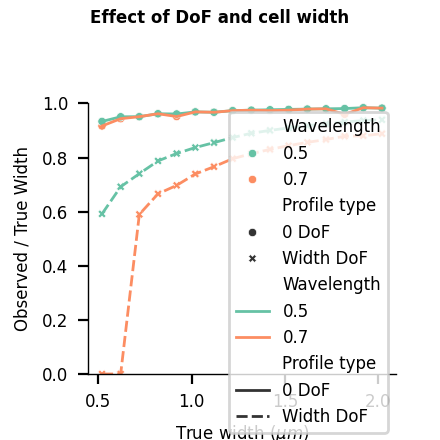

In [74]:
fig, ax = plt.subplots(1,1, figsize=(2.2,2.2), dpi = 200)
sns.scatterplot(data = melted_data.query("`PSF Type` == 'ePSF' & `True Width` <= 2.1"), x = "True Width", y = "Observed Width / True Width", hue = "Wavelength", style="Profile type", palette="Set2")

sns.lineplot(data=melted_data.query("`PSF Type` == 'ePSF' & `True Width` <= 2.1"), 
             x="True Width", 
             y="Observed Width / True Width", 
             hue="Wavelength", 
             style="Profile type", 
             palette="Set2", 
             ax=ax)  # Ensure the line plot is on the same axes


plt.subplots_adjust(left=0.2, top = 0.765, bottom=0.15, right = 0.9)
plt.xlabel("True width ($\mu m$)")
plt.ylabel("Observed / True Width")
plt.suptitle("Effect of DoF and cell width", fontsize = 6, weight = "bold")
plt.ylim(0,1)
plt.savefig("f.svg")

In [75]:
deconv_img = tifffile.imread("../../deconvolution_analysis/deconv_img.tiff")
img_to_deconv = tifffile.imread("../../deconvolution_analysis/img_to_deconv.tiff" )
membrane_cell = tifffile.imread("../../deconvolution_analysis/membrane_cell.tiff")

In [76]:
from scipy.signal import find_peaks

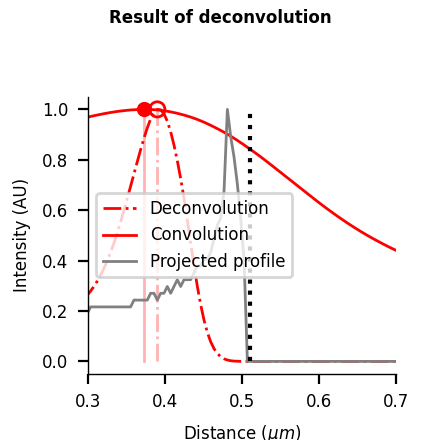

In [94]:
deconv_profile = deconv_img[300]
deconv_profile = deconv_profile/deconv_profile.max()
conv_profile = img_to_deconv[300]
conv_profile = conv_profile/conv_profile.max()
x_axis = np.arange(-len(deconv_profile)/2, len(deconv_profile)/2)*pix_mic_conv

conv_peaks = find_peaks(conv_profile, height = 0.8)[0]
deconv_peaks = find_peaks(deconv_profile, height = 0.8)[0]

fig, ax = plt.subplots(1,1, figsize=(2.2,2.2), dpi = 200)
plt.scatter(x_axis[deconv_peaks],deconv_profile[deconv_peaks], edgecolors='r', facecolors='none', s = 30)
plt.plot(x_axis,deconv_profile/deconv_profile.max(), label = "Deconvolution", c = "red", linestyle = "dashdot")
plt.plot([x_axis[deconv_peaks[-1]], x_axis[deconv_peaks[-1]]],[0,conv_profile[deconv_peaks[-1]]], c = "red", linestyle = "dashdot", alpha = 0.3)

plt.plot(x_axis,conv_profile/conv_profile.max(), label = "Convolution", c = "red")
plt.scatter(x_axis[conv_peaks],conv_profile[conv_peaks], c = "red", s = 20)
plt.plot([x_axis[conv_peaks[-1]], x_axis[conv_peaks[-1]]],[0,conv_profile[conv_peaks[-1]]], c = "red", alpha = 0.3)


plt.plot(x_axis,unconv_profile/unconv_profile.max(), c = "grey", label = "Projected profile")
plt.suptitle("Result of deconvolution", fontsize=6, weight = "bold")
plt.xlabel("Distance ($\mu m$)")
plt.ylabel("Intensity (AU)")
plt.subplots_adjust(left=0.2, top = 0.78, bottom=0.15, right = 0.9)
plt.plot([sim_width/2, sim_width/2],[0,1], c = "k", linestyle = ":", linewidth=1.5)
plt.xlim(0.3,0.7)
plt.legend()

plt.savefig("g.svg")